<a href="https://colab.research.google.com/github/hyunku/cat-and-dog-Classification/blob/main/cat_and_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, Conv2D, GlobalAveragePooling2D, Flatten, GlobalAveragePooling2D, Reshape, Concatenate
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import sklearn

In [ ]:
paths = []
data_trte = []
label_trte = []

In [ ]:
ROOT_PATH = "/content/gdrive/MyDrive/PythonProjects/datafiles/cat_and_dog"
SUBMIT_PATH = "/content/gdrive/MyDrive/PythonProjects/datafiles/Test1"
SUBMIT_FILE = "/content/gdrive/MyDrive/PythonProjects/datafiles/Test0/1조_Submission.csv"

In [ ]:
for dirname, _, filenames in os.walk(ROOT_PATH):
  for filename in filenames:
    if ".jpg" in filename:
      file_path = dirname + '/' + filename
      paths.append(file_path)
      if "/training_set/" in file_path:
        data_trte.append('train')
      elif "/test_set/" in file_path:
        data_trte.append('test')
      else:
        data_trte.append('N/A')

      if 'dogs' in file_path:
        label_trte.append('DOG')
      elif 'cats' in file_path:
        label_trte.append('CAT')
      else:
        label_trte.append('N/A')

In [ ]:
data_df = pd.DataFrame({'path': paths, 'dataset':data_trte, 'label':label_trte})
data_df

,path,dataset,label
0,/content/gdrive/MyDrive/PythonProjects/datafil...,train,CAT
1,/content/gdrive/MyDrive/PythonProjects/datafil...,train,CAT
2,/content/gdrive/MyDrive/PythonProjects/datafil...,train,CAT
3,/content/gdrive/MyDrive/PythonProjects/datafil...,train,CAT
4,/content/gdrive/MyDrive/PythonProjects/datafil...,train,CAT
...,...,...,...
10023,/content/gdrive/MyDrive/PythonProjects/datafil...,test,DOG
10024,/content/gdrive/MyDrive/PythonProjects/datafil...,test,DOG
10025,/content/gdrive/MyDrive/PythonProjects/datafil...,test,DOG
10026,/content/gdrive/MyDrive/PythonProjects/datafil...,test,DOG


In [ ]:
data_df['dataset'].value_counts()

train    8005
test     2023
Name: dataset, dtype: int64

In [ ]:
data_df['label'].value_counts()

DOG    5017
CAT    5011
Name: label, dtype: int64

In [ ]:
data_df[data_df['dataset'] == 'train']['label'].value_counts()

DOG    4005
CAT    4000
Name: label, dtype: int64

In [ ]:
# train/test 셋으로 분리
train_df = data_df[data_df['dataset'] == 'train'].iloc[:,[0,2]]
test_df = data_df[data_df['dataset'] == 'test'].iloc[:,[0,2]]

In [ ]:
# 모델에 넣을 array형태로 변환
train_path = train_df['path'].values
train_label = pd.get_dummies(train_df['label']).values

In [ ]:
train_path

array(['/content/gdrive/MyDrive/PythonProjects/datafiles/cat_and_dog/training_set/cats/cat.3456.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/cat_and_dog/training_set/cats/cat.3406.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/cat_and_dog/training_set/cats/cat.3575.jpg',
       ...,
       '/content/gdrive/MyDrive/PythonProjects/datafiles/cat_and_dog/training_set/dogs/dog.1173.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/cat_and_dog/training_set/dogs/dog.1408.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/cat_and_dog/training_set/dogs/dog.1502.jpg'],
      dtype=object)

In [ ]:
def show_img(img_path_list, ncols=8):
  fig, axs = plt.subplots(figsize=(22,6), nrows=1, ncols=ncols)
  for i in range(ncols):
    image = cv2.cvtColor(cv2.imread(img_path_list[i]), cv2.COLOR_BGR2RGB)
    axs[i].imshow(image)

In [ ]:
dog_img_list = data_df[data_df['label'] == 'DOG']['path'].iloc[:10].tolist()
cat_img_list = data_df[data_df['label'] == 'CAT']['path'].iloc[:10].tolist()

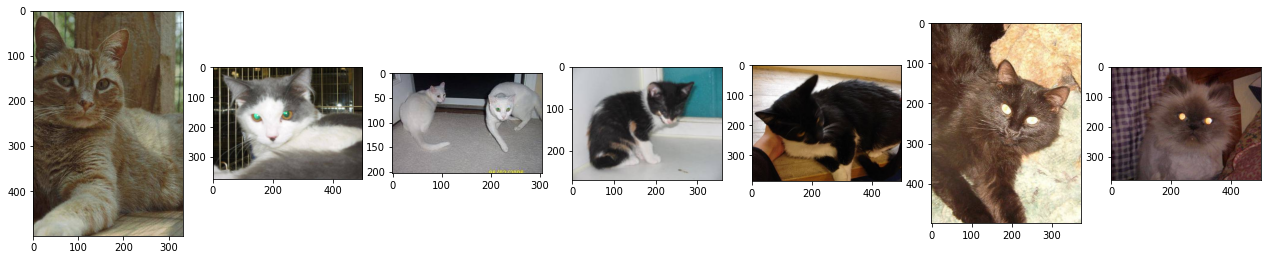

In [ ]:
show_img(cat_img_list, ncols=7)

In [ ]:
import albumentations as A

In [ ]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
N_EPOCHS = 20

In [ ]:
# 데이터셋 만들기 (인풋값은 df가 아닌 array형태로 들어와야함)
# 데이터셋 만들기 (resize, augmentation, batch 처리 등등 다양한 전처리 기능들을 포함.)
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        self.image_size = image_size
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.image_filenames)/BATCH_SIZE))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            image = cv2.resize(image, (self.image_size, self.image_size))
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image    
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [ ]:
# CNN 모델 - 기초
# Convolution 연산 공식 F = 2P + 1, 홀수 풀링시 feature map 반올림X 내림O
def create_model(): 
  input_tensor = Input(shape=(128,128,3)) # 128 * 128 * 3
  x = Conv2D(16,(5,5), activation='relu')(input_tensor) # 124 * 124 * 16
  x = MaxPooling2D(2)(x) # 62 * 62 * 16
  x = Conv2D(32,(3,3), activation='relu')(x) # 60 * 60 * 32
  x = MaxPooling2D(2)(x) # 30 * 30 * 32
  x = Dropout(0.2)(x)
  x = Conv2D(64, (3,3), activation='relu')(x) # 28 * 28 * 64
  x = MaxPooling2D(2)(x) # 14 * 14 * 64
  x = Flatten()(x) # 12544
  x = Dense(64, activation='relu')(x) # 64
  output = Dense(2, activation='sigmoid')(x) # 2
  model = Model(inputs=input_tensor, outputs=output)
  model.summary()
  return model

In [ ]:
# CNN 모델2 - 심화
def create_model2(): 
  input_tensor = Input(shape=(128,128,3)) # 128 * 128 * 3
  x1 = Conv2D(16,(5,5), activation='relu')(input_tensor) # 124 * 124 * 16
  x1 = MaxPooling2D(2)(x1) # 62 * 62 * 16
  x1 = Conv2D(32,(3,3), activation='relu')(x1) # 60 * 60 * 32
  x1 = MaxPooling2D(2)(x1) # 30 * 30 * 32
  x1 = Dropout(0.2)(x1)

  x2 = Conv2D(16, (3,3), activation='relu')(input_tensor) # 126 * 126 * 16
  x2 = MaxPooling2D(3)(x2) # 42 * 42 * 16
  x2 = Conv2D(32, (3,3), activation='relu')(x2) # 40 * 40 * 32
  x2 = MaxPooling2D(2)(x2) # 20 * 20 * 32
  x2 = Dropout(0.2)(x2)
  x2 = Flatten()(x2) # 25600
  x2 = Dense(30*30*16, activation='relu')(x2) # 30 * 30 * 16 (벡터)
  x2 = Reshape((30,30,16))(x2) # 30 * 30 * 16

  x = Concatenate(axis=-1)([x1,x2]) # 30 * 30 * (32 + 16)
  x = GlobalAveragePooling2D()(x) # 48
  x = Dense(16, activation='relu')(x) # 16
  output = Dense(2, activation='sigmoid')(x) # 2

  model = Model(inputs=input_tensor, outputs=output)
  model.summary()
  return model

In [ ]:
# pretrained 모델 사용하는 경우 
def create_pretrained_model(model_name='mymodel', in_shape=(224,224,3), n_classes=2):
  input_tensor = Input(shape=in_shape) # 224 * 224 * 3
  if model_name == 'resnet50v2':
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
  elif model_name == 'xception':
    base_model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
  elif model_name == 'efficientnetb0':
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  preds = Dense(units=n_classes, activation='sigmoid')(x)
  model = Model(inputs=input_tensor, outputs=preds)
  return model

In [ ]:
tr_ds = CnD_Dataset(train_path, train_label, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, 
                          shuffle=True, pre_func=None)

In [ ]:
#next(iter(ds)) -> 데이터셋이 잘 작동하였는지 확인 
images_batch = next(iter(tr_ds))[0]
labels_batch = next(iter(tr_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 128, 128, 3) (64, 2)
[[[ 78.  60.  43.]
  [ 79.  62.  42.]
  [ 79.  60.  44.]
  ...
  [ 94.  86.  61.]
  [ 94.  81.  54.]
  [101.  84.  58.]]

 [[ 72.  51.  38.]
  [ 72.  51.  37.]
  [ 77.  59.  41.]
  ...
  [ 94.  86.  64.]
  [ 98.  86.  61.]
  [ 99.  82.  56.]]

 [[ 69.  50.  36.]
  [ 66.  46.  32.]
  [ 70.  48.  35.]
  ...
  [ 85.  72.  51.]
  [ 88.  73.  48.]
  [ 90.  74.  47.]]

 ...

 [[150. 155. 142.]
  [149. 152. 135.]
  [148. 150. 131.]
  ...
  [119. 113.  87.]
  [120. 116.  91.]
  [120. 113.  93.]]

 [[148. 155. 142.]
  [149. 156. 144.]
  [147. 150. 135.]
  ...
  [112. 104.  80.]
  [124. 118.  96.]
  [120. 113.  94.]]

 [[149. 148. 130.]
  [152. 154. 136.]
  [147. 149. 134.]
  ...
  [ 98.  87.  65.]
  [106.  99.  78.]
  [119. 113.  94.]]]


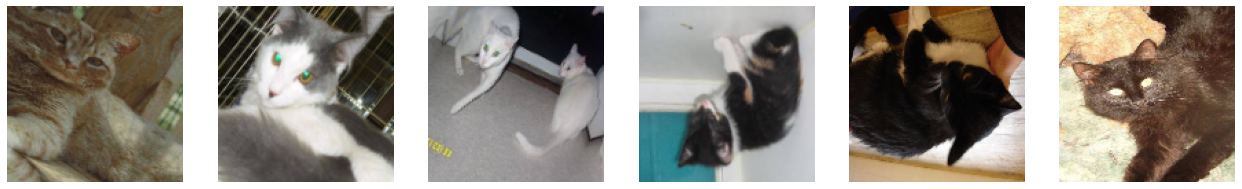

In [ ]:
def show_dataset_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # image_batch는 float형이므로 int형으로 변경하여 이미지 시각화
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        # axs[i].set_title(title[i]) 
        
show_dataset_images(images_batch, ncols=6)

In [ ]:
# 1번 모델(기초)
model = create_model()
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
ely_cb = EarlyStopping(monitor='loss', patience=3, mode='min', verbose=1)
rlr_cb = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, mode='min',verbose=1)
hist = model.fit(tr_ds, epochs=N_EPOCHS, callbacks=([ely_cb, rlr_cb]), steps_per_epoch=int(np.ceil(train_path.shape[0]/BATCH_SIZE)), verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0     

In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,accuracy,lr
0,3.229638,0.583136,0.001
1,0.608590,0.667458,0.001
2,0.569013,0.704934,0.001
3,0.516599,0.745534,0.001
4,0.493798,0.756402,0.001
5,0.444829,0.791131,0.001
6,0.413237,0.810993,0.001
7,0.378824,0.828232,0.001
8,0.341207,0.849094,0.001
9,0.316912,0.858713,0.001


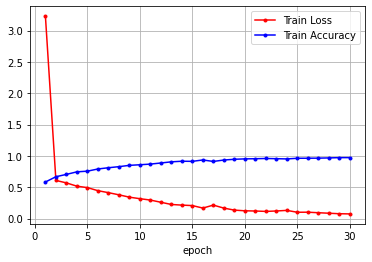

In [ ]:
plt.plot(np.arange(len(hist_df))+1, hist_df['loss'], marker='.', c='red', label='Train Loss')
plt.plot(np.arange(len(hist_df))+1, hist_df['accuracy'], marker='.', c='blue', label='Train Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()

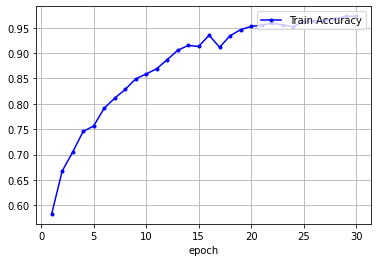

In [ ]:
# plt.plot(np.arange(len(hist_df))+1, hist_df['loss'], marker='.', c='red', label='Train Loss')
plt.plot(np.arange(len(hist_df))+1, hist_df['accuracy'], marker='.', c='blue', label='Train Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()

In [ ]:
# model.save('/content/gdrive/MyDrive/PythonProjects/cat_and_dog_weight/model_30epoch.h5')

In [ ]:
# 2번모델 (심화)
model = create_model2()
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
ely_cb = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)
rlr_cb = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, mode='min',verbose=1)
hist = model.fit(tr_ds, epochs=N_EPOCHS, callbacks=([ely_cb, rlr_cb]), steps_per_epoch=int(np.ceil(train_path.shape[0]/BATCH_SIZE)), verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 126, 126, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 42, 42, 16)  0           ['conv2d_2[0][0]']               
                                                                                              

In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,accuracy,lr
0,1.752392,0.483448,0.0010
1,0.690780,0.525047,0.0010
2,0.690289,0.548657,0.0010
3,0.685496,0.550156,0.0010
4,0.646757,0.621237,0.0010
5,0.587134,0.691568,0.0010
6,0.534031,0.733417,0.0010
7,0.470335,0.775141,0.0010
8,0.407779,0.813117,0.0010
9,0.348586,0.843348,0.0010


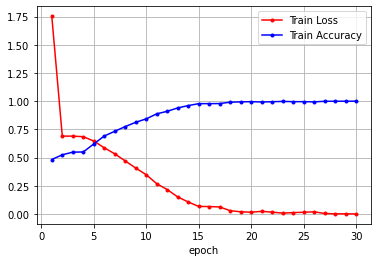

In [ ]:
plt.plot(np.arange(len(hist_df))+1, hist_df['loss'], marker='.', c='red', label='Train Loss')
plt.plot(np.arange(len(hist_df))+1, hist_df['accuracy'], marker='.', c='blue', label='Train Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()

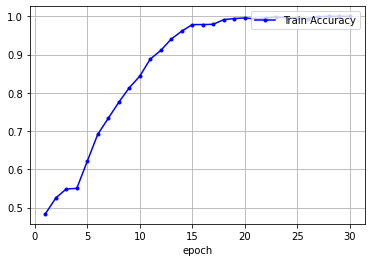

In [ ]:
# plt.plot(np.arange(len(hist_df))+1, hist_df['loss'], marker='.', c='red', label='Train Loss')
plt.plot(np.arange(len(hist_df))+1, hist_df['accuracy'], marker='.', c='blue', label='Train Accuracy')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()

In [ ]:
# model.save('/content/gdrive/MyDrive/PythonProjects/cat_and_dog_weight/model2_30epoch_acc100.h5')

# 모델1 사용하기

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/PythonProjects/cat_and_dog_weight/model2_15epoch_acc94.h5')
# model2 = load_model('/content/gdrive/MyDrive/PythonProjects/cat_and_dog_weight/model_30epoch_acc97.h5')
model2 = load_model('/content/gdrive/MyDrive/PythonProjects/cat_and_dog_weight/model2_30epoch_acc100.h5')

OSError: ignored

In [ ]:
# 모델에 넣을 array형태로 변환
test_path = test_df['path'].values
test_label = pd.get_dummies(test_df['label']).values

In [ ]:
test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                          shuffle=True, pre_func=None)

In [ ]:
model.evaluate(test_ds)

32/32 [==============================] - 510s 16s/step - loss: 1.2598 - accuracy: 0.7420


[1.2598292827606201, 0.7419673800468445]

In [ ]:
test_label

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [ ]:
testing_df = test_df.copy()
testing_df

,path,label
8005,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT
8006,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT
8007,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT
8008,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT
8009,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT
...,...,...
10023,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG
10024,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG
10025,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG
10026,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG


In [ ]:
# 원핫인코딩된 target label에서 argmax로 타겟 값 추출 -> 레이블 인코딩
testing_df['label_enc'] = np.argmax(test_label, axis=1)

In [ ]:
testing_df

,path,label,label_enc
8005,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0
8006,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0
8007,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0
8008,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0
8009,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0
...,...,...,...
10023,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1
10024,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1
10025,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1
10026,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1


In [ ]:
# 모델 사용하여 예측
predict_result = model.predict(test_ds)
# argmax로 최대값 인덱스 추출하여 예측 클래스 도출
predict_class = np.argmax(predict_result, axis=1)
# 예측한 클래스 값을 df에 추가
testing_df['predicted_class'] = predict_class

32/32 [==============================] - 55s 2s/step


In [ ]:
testing_df

,path,label,label_enc,predicted_class
8005,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,0
8006,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,0
8007,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,0
8008,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,1
8009,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,1
...,...,...,...,...
10023,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,1
10024,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,1
10025,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,1
10026,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,1


In [ ]:
testing_df[testing_df['label_enc'] != testing_df['predicted_class']]

,path,label,label_enc,predicted_class
8008,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,1
8009,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,1
8014,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,1
8018,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,1
8020,/content/gdrive/MyDrive/PythonProjects/datafil...,CAT,0,1
...,...,...,...,...
10018,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,0
10019,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,0
10021,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,0
10022,/content/gdrive/MyDrive/PythonProjects/datafil...,DOG,1,0


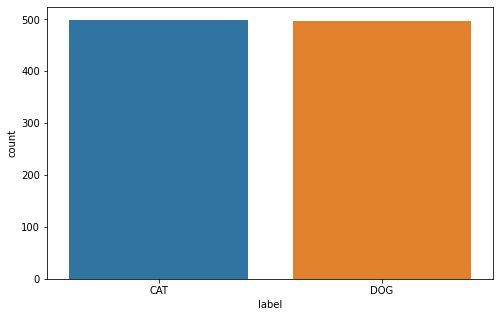

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,5))
wrong_result_df = testing_df[testing_df['label_enc'] != testing_df['predicted_class']]
sns.countplot(data=wrong_result_df, x='label')

In [ ]:
real_acc = (len(wrong_result_df) / len(testing_df)) * 100
print(f'모델의 실제 정확도 : {real_acc:.2f} %')

모델의 실제 정확도 : 49.23 %


# 틀리게 예측한 데이터 시각화

In [ ]:
dog_img_wrong_list = wrong_result_df[wrong_result_df['label'] == 'DOG']['path'].iloc[:10].tolist()
cat_img_wrong_list = wrong_result_df[wrong_result_df['label'] == 'CAT']['path'].iloc[:10].tolist()

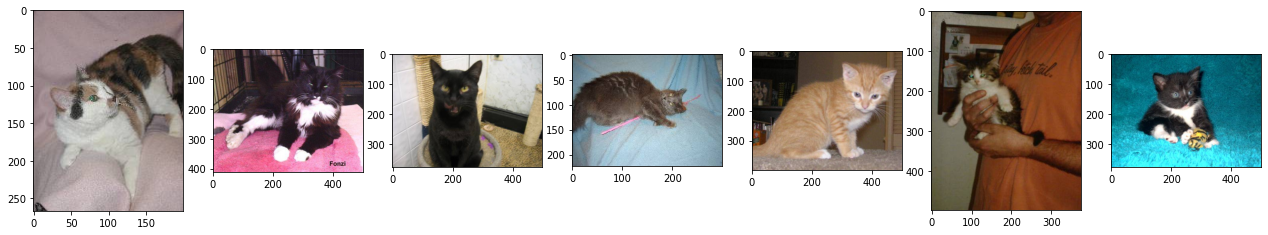

In [ ]:
show_img(cat_img_wrong_list, ncols=7)

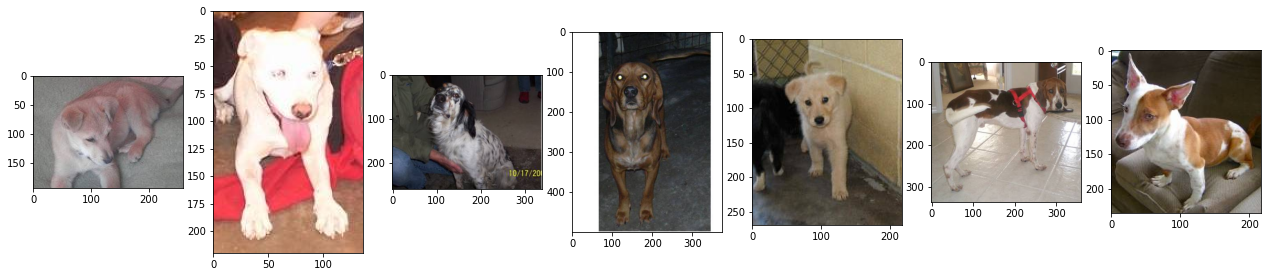

In [ ]:
show_img(dog_img_wrong_list, ncols=7)

# 모델 2 사용하기

In [ ]:
model2 = load_model('/content/gdrive/MyDrive/PythonProjects/cat_and_dog_weight/model_30epoch_acc97.h5')
model2.evaluate(test_ds)

NameError: ignored

In [ ]:
testing_df = test_df.copy()
testing_df['label_enc'] = np.argmax(test_label, axis=1)
predict_result = model2.predict(test_ds)
predict_class = np.argmax(predict_result, axis=1)
testing_df['predicted_class'] = predict_class

32/32 [==============================] - 22s 676ms/step


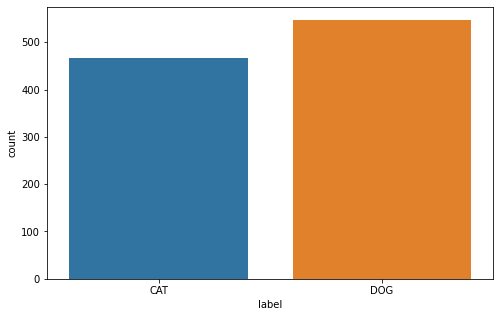

In [ ]:
plt.figure(figsize=(8,5))
wrong_result_df = testing_df[testing_df['label_enc'] != testing_df['predicted_class']]
sns.countplot(data=wrong_result_df, x='label')

In [ ]:
real_acc = (len(wrong_result_df) / len(testing_df)) * 100
print(f'모델의 실제 정확도 : {real_acc:.2f} %')

모델의 실제 정확도 : 50.12 %


# Competetion

In [ ]:
# 제출 파일들 리스트화
file_path_com = [x for x in os.listdir(SUBMIT_PATH)]
file_path_com

['18.jpg',
 '17.jpg',
 '15.jpg',
 '14.jpg',
 '13.jpg',
 '16.jpg',
 '11.jpg',
 '10.jpg',
 '12.jpg',
 '100.jpg',
 '1.jpg',
 '46.jpg',
 '47.jpg',
 '48.jpg',
 '45.jpg',
 '41.jpg',
 '42.jpg',
 '43.jpg',
 '4.jpg',
 '44.jpg',
 '40.jpg',
 '38.jpg',
 '37.jpg',
 '39.jpg',
 '35.jpg',
 '32.jpg',
 '33.jpg',
 '34.jpg',
 '31.jpg',
 '36.jpg',
 '30.jpg',
 '28.jpg',
 '3.jpg',
 '29.jpg',
 '27.jpg',
 '25.jpg',
 '23.jpg',
 '26.jpg',
 '21.jpg',
 '24.jpg',
 '22.jpg',
 '2.jpg',
 '19.jpg',
 '20.jpg',
 '84.jpg',
 '82.jpg',
 '83.jpg',
 '81.jpg',
 '78.jpg',
 '77.jpg',
 '79.jpg',
 '80.jpg',
 '8.jpg',
 '76.jpg',
 '73.jpg',
 '75.jpg',
 '74.jpg',
 '72.jpg',
 '71.jpg',
 '70.jpg',
 '7.jpg',
 '69.jpg',
 '68.jpg',
 '64.jpg',
 '66.jpg',
 '65.jpg',
 '67.jpg',
 '63.jpg',
 '60.jpg',
 '61.jpg',
 '62.jpg',
 '6.jpg',
 '56.jpg',
 '58.jpg',
 '59.jpg',
 '57.jpg',
 '55.jpg',
 '54.jpg',
 '52.jpg',
 '49.jpg',
 '5.jpg',
 '53.jpg',
 '51.jpg',
 '50.jpg',
 '98.jpg',
 '95.jpg',
 '96.jpg',
 '97.jpg',
 '99.jpg',
 '93.jpg',
 '92.jpg',
 '94.j

In [ ]:
# 절대경로
compete_li = [SUBMIT_PATH + '/' + x for x in fill_path_com]

In [ ]:
# 절대경로
compete_li = []
for i in file_path_com:
  compete_li.append(SUBMIT_PATH + '/' + i)

In [ ]:
# array 변환
compete_arr = np.array(compete_li)
compete_arr

array(['/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/18.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/17.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/15.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/14.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/13.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/16.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/11.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/10.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/12.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/100.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/1.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/46.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/47.jpg',
       '/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/4

In [ ]:
# 데이터셋 만들기 (인풋값은 df가 아닌 array형태로 들어와야함)
# 데이터셋 만들기 (resize, augmentation, batch 처리 등등 다양한 전처리 기능들을 포함.)
class CnD_Dataset_com(Sequence):
    def __init__(self, image_filenames, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        self.image_size = image_size
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.image_filenames)/BATCH_SIZE))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            image = cv2.resize(image, (self.image_size, self.image_size))
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image    
        return image_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [ ]:
# 데이터 전처리
compete_data = CnD_Dataset_com(compete_arr)

In [ ]:
# 모델 예측
result = model.predict(compete_data)

2/2 [==============================] - 2s 657ms/step


In [ ]:
# 예측값
predict_class = np.argmax(result, axis=1)
predict_class

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1])

In [ ]:
# 예측값 데이터프레임
dfdf = pd.DataFrame(predict_class)
dfdf

,0
0,1
1,1
2,0
3,0
4,0
...,...
95,0
96,1
97,1
98,0


In [ ]:
idx_num = [x for x in range(1,101)]
idx_num

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100]

In [ ]:
dfdf.index = idx_num
dfdf

,0
1,1
2,1
3,0
4,0
5,0
...,...
96,0
97,1
98,1
99,0


In [ ]:
# submit = dfdf.to_csv('/content/gdrive/MyDrive/PythonProjects/datafiles/Test1/submission_3조.csv')